In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os
import json

from tqdm import tqdm

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
DATA_IN_PATH = './data/'
DATA_OUT_PATH = './data/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

In [4]:
SEED_NUM = 13
tf.random.set_seed(SEED_NUM)

In [5]:
train_input = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [6]:
prepro_configs

{'vocab': {'movie': 1,
  'film': 2,
  'one': 3,
  'like': 4,
  'good': 5,
  'time': 6,
  'even': 7,
  'would': 8,
  'story': 9,
  'really': 10,
  'see': 11,
  'well': 12,
  'much': 13,
  'get': 14,
  'bad': 15,
  'people': 16,
  'also': 17,
  'first': 18,
  'great': 19,
  'made': 20,
  'way': 21,
  'make': 22,
  'could': 23,
  'movies': 24,
  'think': 25,
  'characters': 26,
  'character': 27,
  'watch': 28,
  'two': 29,
  'films': 30,
  'seen': 31,
  'many': 32,
  'life': 33,
  'plot': 34,
  'acting': 35,
  'never': 36,
  'love': 37,
  'little': 38,
  'best': 39,
  'show': 40,
  'know': 41,
  'ever': 42,
  'man': 43,
  'better': 44,
  'end': 45,
  'still': 46,
  'say': 47,
  'scene': 48,
  'scenes': 49,
  'go': 50,
  'something': 51,
  'back': 52,
  'real': 53,
  'watching': 54,
  'though': 55,
  'thing': 56,
  'old': 57,
  'years': 58,
  'actors': 59,
  'director': 60,
  'work': 61,
  'another': 62,
  'new': 63,
  'nothing': 64,
  'funny': 65,
  'actually': 66,
  'makes': 67,
  'look

In [7]:
model_name = 'rnn_classifier_en'
BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name' : model_name,
        'vocab_size' : prepro_configs['vocab_size'],
        'embedding_dimension' : 100,
        'dropout_rate' : 0.2,
        'lstm_dimesion' : 150,
        'dense_dimension' : 150,
        'output_dimension' : 1}

In [20]:
# 모델 구현
class RNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(RNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                          output_dim=kargs['embedding_dimension'])
        self.lstm_1_layer = tf.keras.layers.LSTM(kargs['lstm_dimesion'],
                                                      return_sequences=True)
        self.lstm_2_layer = tf.keras.layers.LSTM(kargs['lstm_dimesion'])
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['dense_dimension'],
                                activation=tf.keras.activations.tanh)
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                               activation=tf.keras.activations.sigmoid)

    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm_1_layer(x)
        x = self.lstm_2_layer(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [21]:
model = RNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [22]:
# overfitting을 막기 위한 earlystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)

In [23]:
# cp_callback
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists in \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(
            checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True,
            save_weights_only=True)
# 최고 성능을 보인 에포크에서 모델 저장

./data/rnn_classifier_en -- Folder already exists in 



In [24]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS, validation_split=VALID_SPLIT,
                   callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
176/176 [==============================] - 143s 798ms/step - loss: 0.6932 - accuracy: 0.5030 - val_loss: 0.6928 - val_accuracy: 0.5016

Epoch 00001: val_accuracy improved from -inf to 0.50160, saving model to ./data/rnn_classifier_en/weights.h5
Epoch 2/5
176/176 [==============================] - 131s 742ms/step - loss: 0.6917 - accuracy: 0.5016 - val_loss: 0.5743 - val_accuracy: 0.6956

Epoch 00002: val_accuracy improved from 0.50160 to 0.69560, saving model to ./data/rnn_classifier_en/weights.h5
Epoch 3/5
176/176 [==============================] - 126s 714ms/step - loss: 0.4152 - accuracy: 0.8172 - val_loss: 0.2988 - val_accuracy: 0.8808

Epoch 00003: val_accuracy improved from 0.69560 to 0.88080, saving model to ./data/rnn_classifier_en/weights.h5
Epoch 4/5
176/176 [==============================] - 124s 704ms/step - loss: 0.2028 - accuracy: 0.9240 - val_loss: 0.2866 - val_accuracy: 0.8864

Epoch 00004: val_accuracy improved from 0.88080 to 0.88640, saving model to ./data/

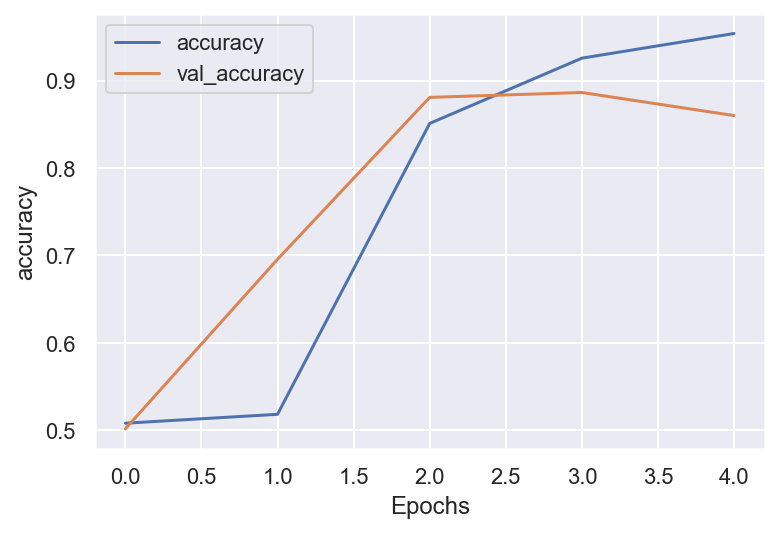

In [25]:
plot_graphs(history, 'accuracy')

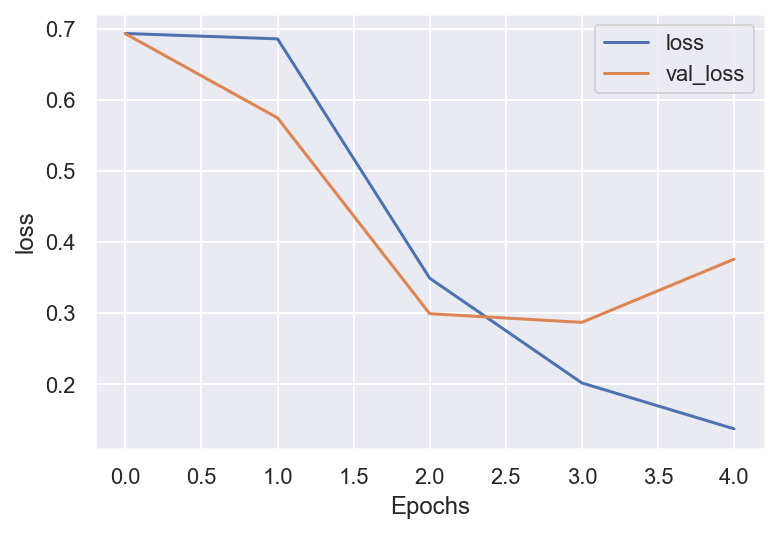

In [26]:
plot_graphs(history, 'loss')

In [28]:
DATA_OUT_PATH = './data/'
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'

test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])

In [29]:
SAVE_FILE_NM = 'weights.h5'

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [30]:
predictions = model.predict(test_input, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

In [31]:
predictions

array([0.99187064, 0.02055839, 0.8555362 , ..., 0.08815682, 0.9866705 ,
       0.7325983 ], dtype=float32)

In [32]:
test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)

if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

output = pd.DataFrame(data={'id':list(test_id), 'sentiment':list(predictions)})
output.to_csv(DATA_OUT_PATH + 'movie_review_result_rnn.csv', index=False, quoting=3)

### CNN을 이용한 분류

In [33]:
model_name = 'cnn_classifier_en'
BATCH_SIZE = 512
NUM_EPOCHS = 5
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name' : model_name,
        'vocab_size' : prepro_configs['vocab_size'],
        'embedding_size' : 128,
        'num_filters' : 100,
        'dropout_rate' : 0.5,
        'hidden_dimesion' : 250,
        'output_dimension' : 1}

In [35]:
# 모델 구현
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                          output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                       kernel_size=kernel_size,
                                       padding='valid',
                                       activation=tf.keras.activations.relu,
                                       kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                         for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPool1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                                activation=tf.keras.activations.relu,
                                kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                                activation=tf.keras.activations.sigmoid,
                                kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [36]:
# overfitting을 막기 위한 earlystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

# cp_callback
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists in \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(
            checkpoint_path, monitor='val_accuracy', verbose=1,
            save_best_only=True, save_weights_only=True)
            # 최고 성능을 보인 에포크에서 모델 저장

./data/cnn_classifier_en -- Folder create complete 



In [37]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS, validation_split=VALID_SPLIT,
                   callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
44/44 [==============================] - 95s 2s/step - loss: 0.1240 - accuracy: 0.9598 - val_loss: 0.3089 - val_accuracy: 0.8836

Epoch 00001: val_accuracy improved from -inf to 0.88360, saving model to ./data/cnn_classifier_en/weights.h5
Epoch 2/5
44/44 [==============================] - 97s 2s/step - loss: 0.1068 - accuracy: 0.9648 - val_loss: 0.3170 - val_accuracy: 0.8872

Epoch 00002: val_accuracy improved from 0.88360 to 0.88720, saving model to ./data/cnn_classifier_en/weights.h5
Epoch 3/5
44/44 [==============================] - 89s 2s/step - loss: 0.0881 - accuracy: 0.9728 - val_loss: 0.3512 - val_accuracy: 0.8900

Epoch 00003: val_accuracy improved from 0.88720 to 0.89000, saving model to ./data/cnn_classifier_en/weights.h5
Epoch 4/5
44/44 [==============================] - 92s 2s/step - loss: 0.0794 - accuracy: 0.9764 - val_loss: 0.3889 - val_accuracy: 0.8848

Epoch 00004: val_accuracy did not improve from 0.89000
Epoch 5/5
44/44 [==============================] - 8

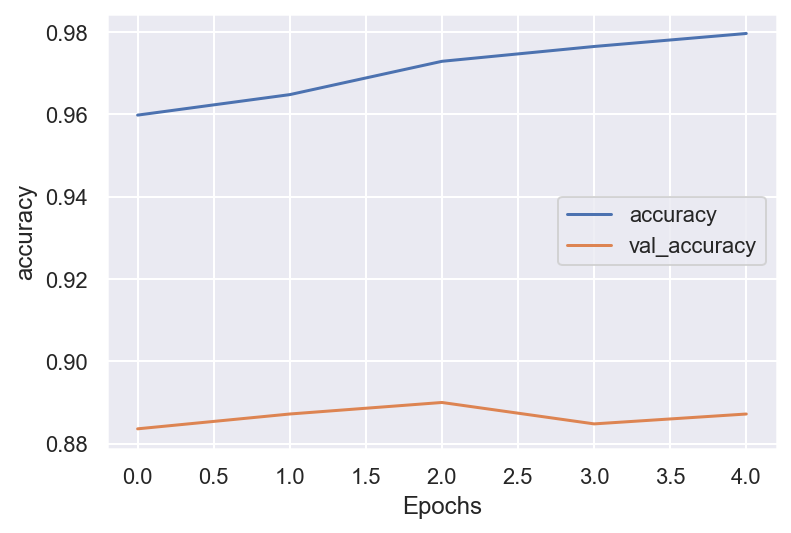

In [38]:
plot_graphs(history, 'accuracy')

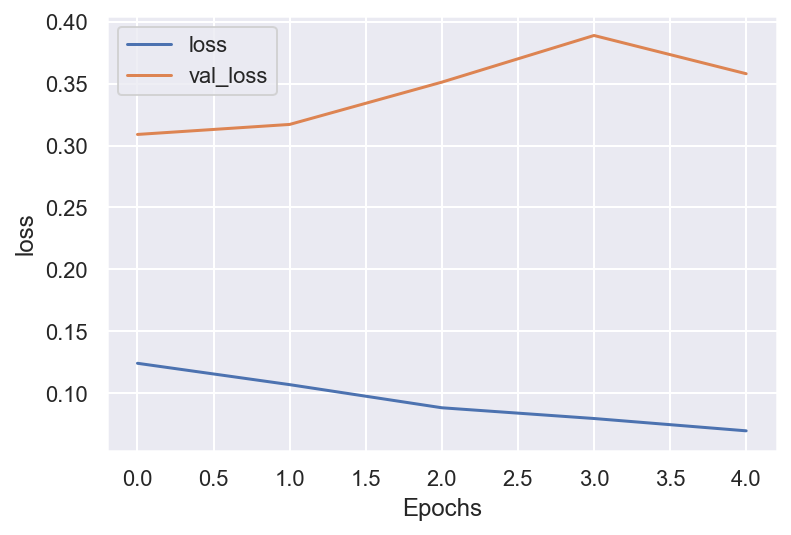

In [39]:
plot_graphs(history, 'loss')

In [40]:
DATA_OUT_PATH = './data/'
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'

test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])

In [41]:
SAVE_FILE_NM = 'weights.h5'

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [42]:
predictions = model.predict(test_input, batch_size=BATCH_SIZE)
predictions = predictions.squeeze(-1)

In [44]:
test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'), allow_pickle=True)

if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

output = pd.DataFrame(data={'id':list(test_id), 'sentiment':list(predictions)})
output.to_csv(DATA_OUT_PATH + 'movie_review_result_cnn.csv', index=False, quoting=3)